In [30]:
import math
import noise_scheduler

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.auto import tqdm
import pandas as pd

from sklearn.datasets import make_moons
from torch.utils.data import TensorDataset

import ddpm_Time_Series_copy
from ddpm_Time_Series_copy import TimeSeriesDataset

from torch.utils.data import Dataset, DataLoader
import argparse
import os

from torch import nn
from torch.nn import functional as F

from positional_embeddings import PositionalEmbedding

In [38]:
class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

config = {
  "data_path": "../datasets/UTS/WSD/107",
  "output_dir": "output",
  "train_batch_size": 16,
  "eval_batch_size": 16,
  "num_epochs": 1,
  
  "learning_rate": 0.0001,
  "num_timesteps": 1001,
  "beta_schedule": "linear",
  "embedding_size": 128,
  "hidden_size": 128,
  "hidden_layers": 3,
  "time_embedding": "sinusoidal",
  "input_embedding": "sinusoidal",
  "save_eval_step": 10,
  "experiment_name": "NonName",
  "beta_start": 0.0001,
  "beta_end": 0.02,
  "save_model_epochs": 1
}


# Create Config object
config = Config(config)



In [39]:
dataset = TimeSeriesDataset(config.data_path,sequence_length=5000, stride=500,normalize=False)

dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)

# White Gaussian Noise classic 

In [40]:
from noise_scheduler import NoiseScheduler

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

0
tensor([[1273., 1263., 1307.,  ..., 2076., 1681., 1972.],
        [1708., 1760., 1608.,  ...,  319.,  345.,  402.],
        [ 571.,  621.,  572.,  ..., 1596., 1611., 1589.],
        ...,
        [1860., 1845., 1872.,  ..., 1280., 1312., 1254.],
        [ 454.,  503.,  535.,  ..., 1577., 1577.,  668.],
        [1796., 1729., 1796.,  ...,  668.,  734.,  625.]])
tensor([1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5046e+09, 1.5046e+09, 1.5046e+09,
        1.5047e+09, 1.5047e+09, 1.5047e+09, 1.5048e+09, 1.5048e+09, 1.5048e+09,
        1.5048e+09, 1.5049e+09, 1.5049e+09, 1.5049e+09], dtype=torch.float64)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
timesteps tensor([508, 605, 326, 405, 871, 495, 567, 778,  68, 864, 167, 802, 666, 239,
        563, 276])
Batch shape: tor

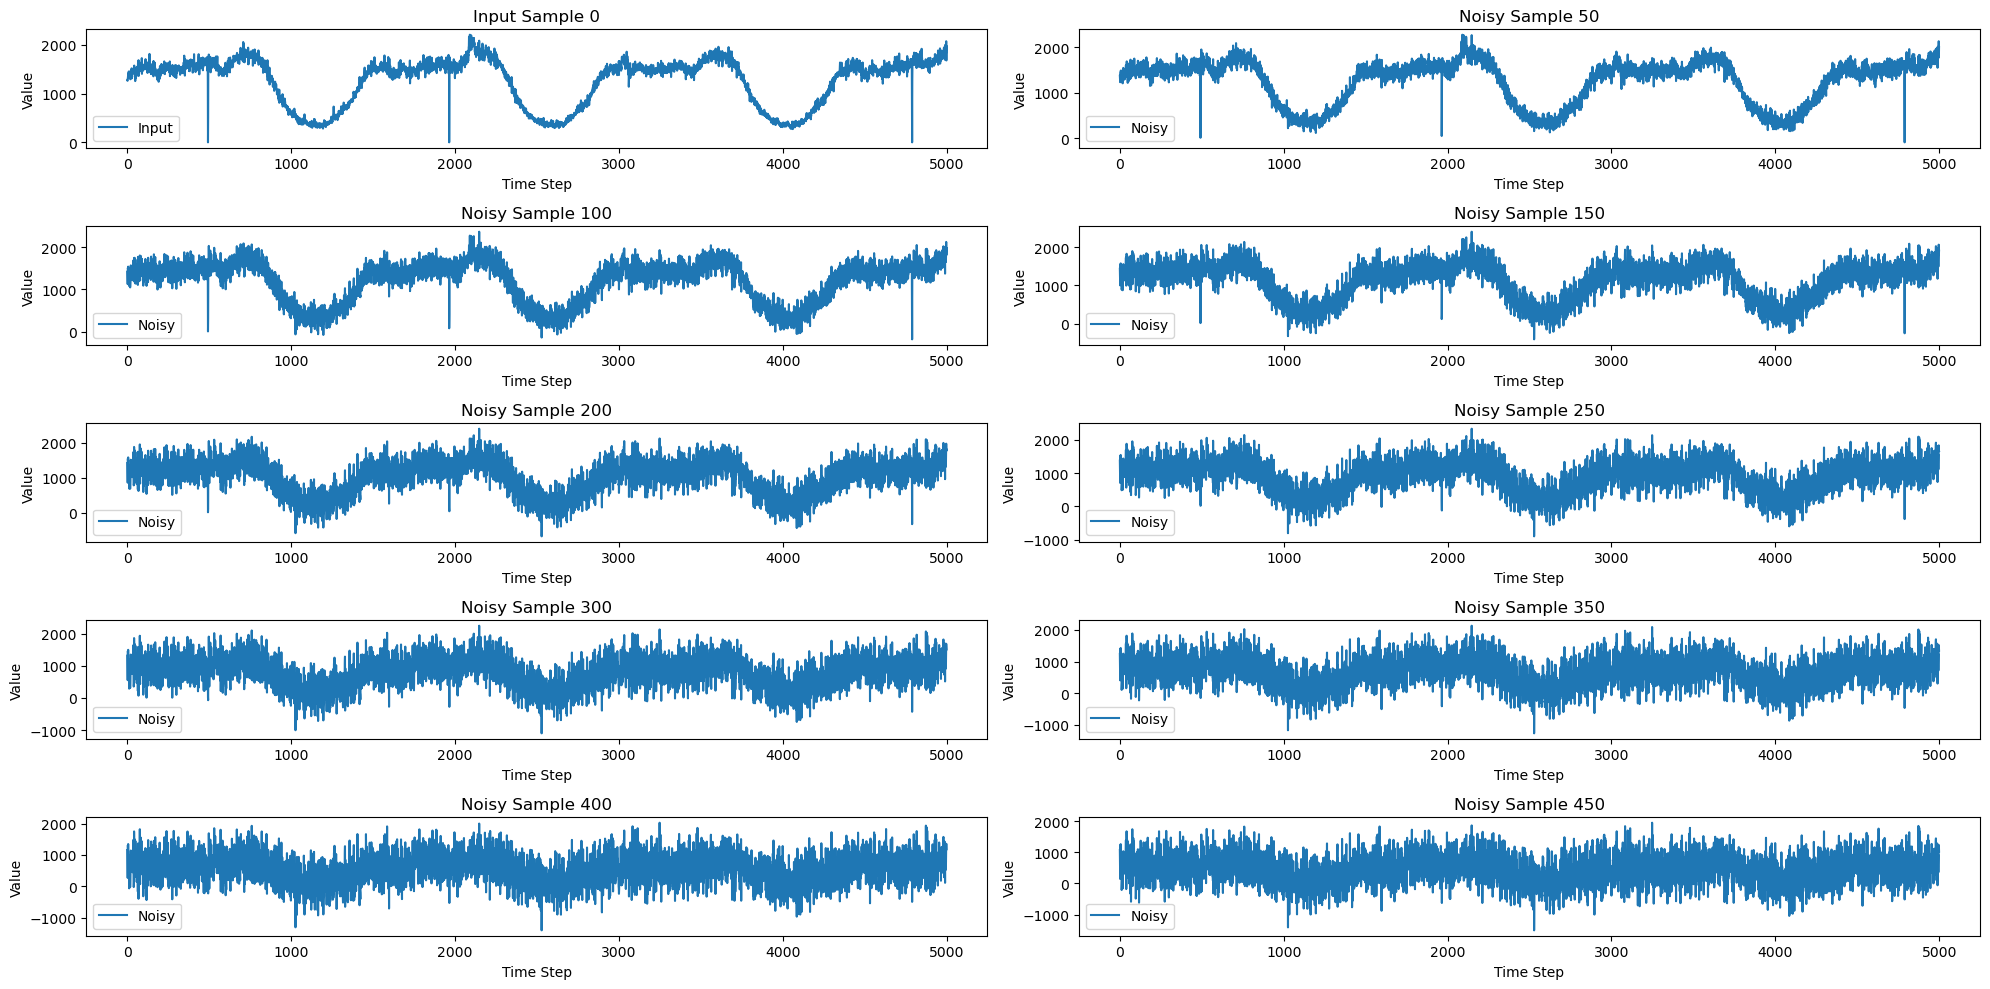

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

Showing input and noisy data


In [47]:

noise_scheduler = NoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

for epoch in range(config.num_epochs):
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch, timestamps, labels) in enumerate(tqdm(dataloader)):
        #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)
        
        std_batch = batch.std(dim=1, keepdim=True)
        
        print(step)
        print(batch)
        print(timestamps)
        print(labels)
        
        noise = torch.randn_like(batch)*std_batch
        
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        print('timesteps', timesteps)

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        
        print(f"Batch shape: {batch.shape}")
        print(f"Noise shape: {noise.shape}")
        print(f"Noisy shape: {noisy.shape}")
        

        # Visualize the input and noisy data 
        fig, axs = plt.subplots(5, 2, figsize=(20, 10))
        
        # Plotting the first sample
        ax = axs[0, 0]
        ax.plot(batch[0].cpu().numpy())
        ax.set_title("Input Sample 0")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Input"])


        # Plotting noisy versions of the first sample
        for i in range(9):
            print( noise[0])
            noisy_sample = noise_scheduler.add_noise(batch[0], noise[0], torch.tensor([(i+1)*50]))
            
            ax = axs[(i+1) // 2, (i+1) % 2]
            ax.plot(noisy_sample[0].cpu().numpy())
            ax.set_title(f"Noisy Sample {(i+1)*50}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Value")
            ax.legend(["Noisy"])

        fig.tight_layout()
        plt.show()
        print("Showing input and noisy data")
        
        break
    
    progress_bar.close()



# Simplex noise

In [48]:
from noise_scheduler import SimplexNoiseScheduler

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

0
tensor([[1273., 1263., 1307.,  ..., 2076., 1681., 1972.],
        [1708., 1760., 1608.,  ...,  319.,  345.,  402.],
        [ 571.,  621.,  572.,  ..., 1596., 1611., 1589.],
        ...,
        [1860., 1845., 1872.,  ..., 1280., 1312., 1254.],
        [ 454.,  503.,  535.,  ..., 1577., 1577.,  668.],
        [1796., 1729., 1796.,  ...,  668.,  734.,  625.]])
tensor([1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5046e+09, 1.5046e+09, 1.5046e+09,
        1.5047e+09, 1.5047e+09, 1.5047e+09, 1.5048e+09, 1.5048e+09, 1.5048e+09,
        1.5048e+09, 1.5049e+09, 1.5049e+09, 1.5049e+09], dtype=torch.float64)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
timesteps tensor([ 59, 844, 565, 485, 210, 439, 397, 278, 981, 883,  31, 550, 525, 841,
        171, 675])
Batch shape: tor

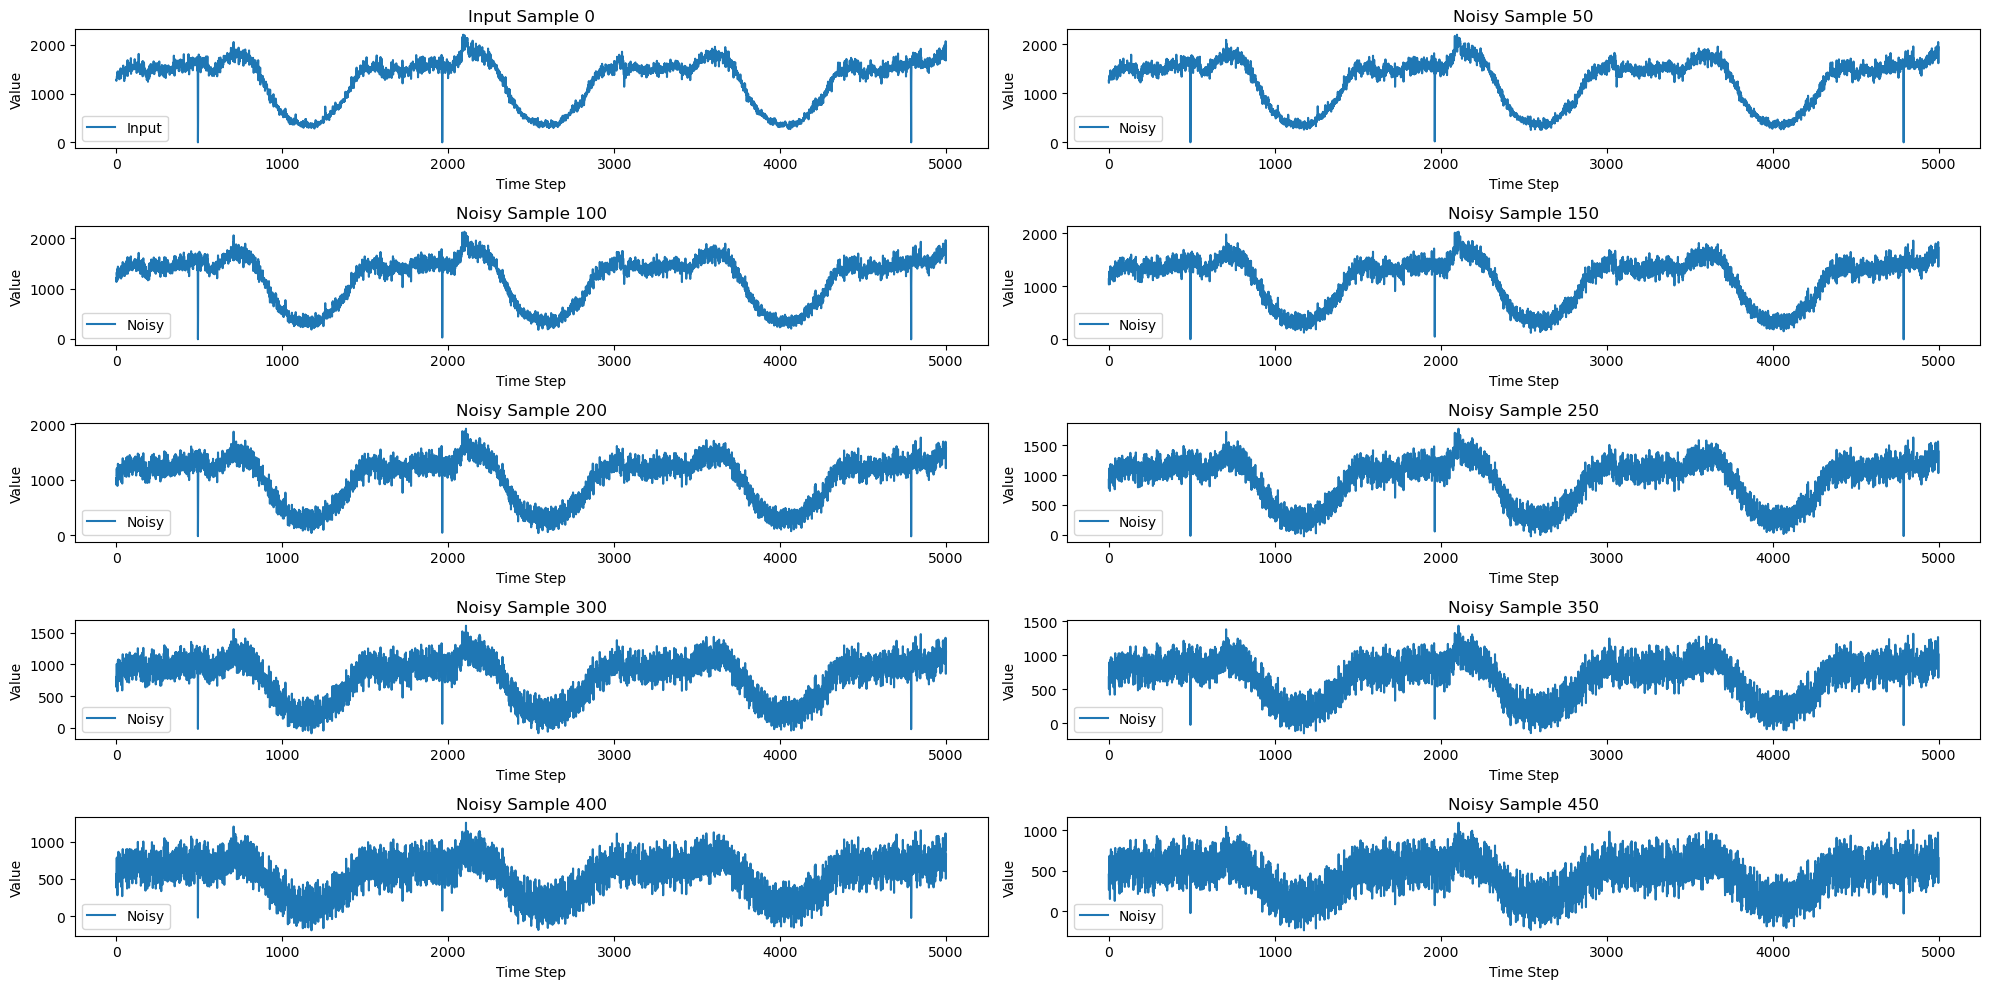

  0%|          | 0/1 [00:01<?, ?it/s]


In [49]:

noise_scheduler = SimplexNoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

for epoch in range(config.num_epochs):

    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch, timestamps, labels) in enumerate(tqdm(dataloader)):
        #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)
        
        print(step)
        print(batch)
        print(timestamps)
        print(labels)
        
        noise = noise_scheduler.generate_simplex_noise_like(batch) * std_batch
        
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        print('timesteps', timesteps)

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        
        print(f"Batch shape: {batch.shape}")
        print(f"Noise shape: {noise.shape}")
        print(f"Noisy shape: {noisy.shape}")
        

        # Visualize the input and noisy data 
        fig, axs = plt.subplots(5, 2, figsize=(20, 10))
        
        # Plotting the first sample
        ax = axs[0, 0]
        ax.plot(batch[0].cpu().numpy())
        ax.set_title("Input Sample 0")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Input"])

        # Plotting noisy versions of the first sample
        for i in range(9):
            noisy_sample = noise_scheduler.add_noise(batch[0], noise[0], torch.tensor([(i+1)*50]))
            ax = axs[(i+1) // 2, (i+1) % 2]
            ax.plot(noisy_sample[0].cpu().numpy())
            ax.set_title(f"Noisy Sample {(i+1)*50}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Value")
            ax.legend(["Noisy"])

        fig.tight_layout()
        plt.show()
        
        break

# Pink noise 

In [50]:
from noise_scheduler import PinkNoiseScheduler

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

0
tensor([[1273., 1263., 1307.,  ..., 2076., 1681., 1972.],
        [1708., 1760., 1608.,  ...,  319.,  345.,  402.],
        [ 571.,  621.,  572.,  ..., 1596., 1611., 1589.],
        ...,
        [1860., 1845., 1872.,  ..., 1280., 1312., 1254.],
        [ 454.,  503.,  535.,  ..., 1577., 1577.,  668.],
        [1796., 1729., 1796.,  ...,  668.,  734.,  625.]])
tensor([1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5046e+09, 1.5046e+09, 1.5046e+09,
        1.5047e+09, 1.5047e+09, 1.5047e+09, 1.5048e+09, 1.5048e+09, 1.5048e+09,
        1.5048e+09, 1.5049e+09, 1.5049e+09, 1.5049e+09], dtype=torch.float64)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
timesteps tensor([408,  21, 133, 859, 953, 497, 672, 820, 415, 814, 185, 463, 900, 559,
        925, 935])
Batch shape: tor

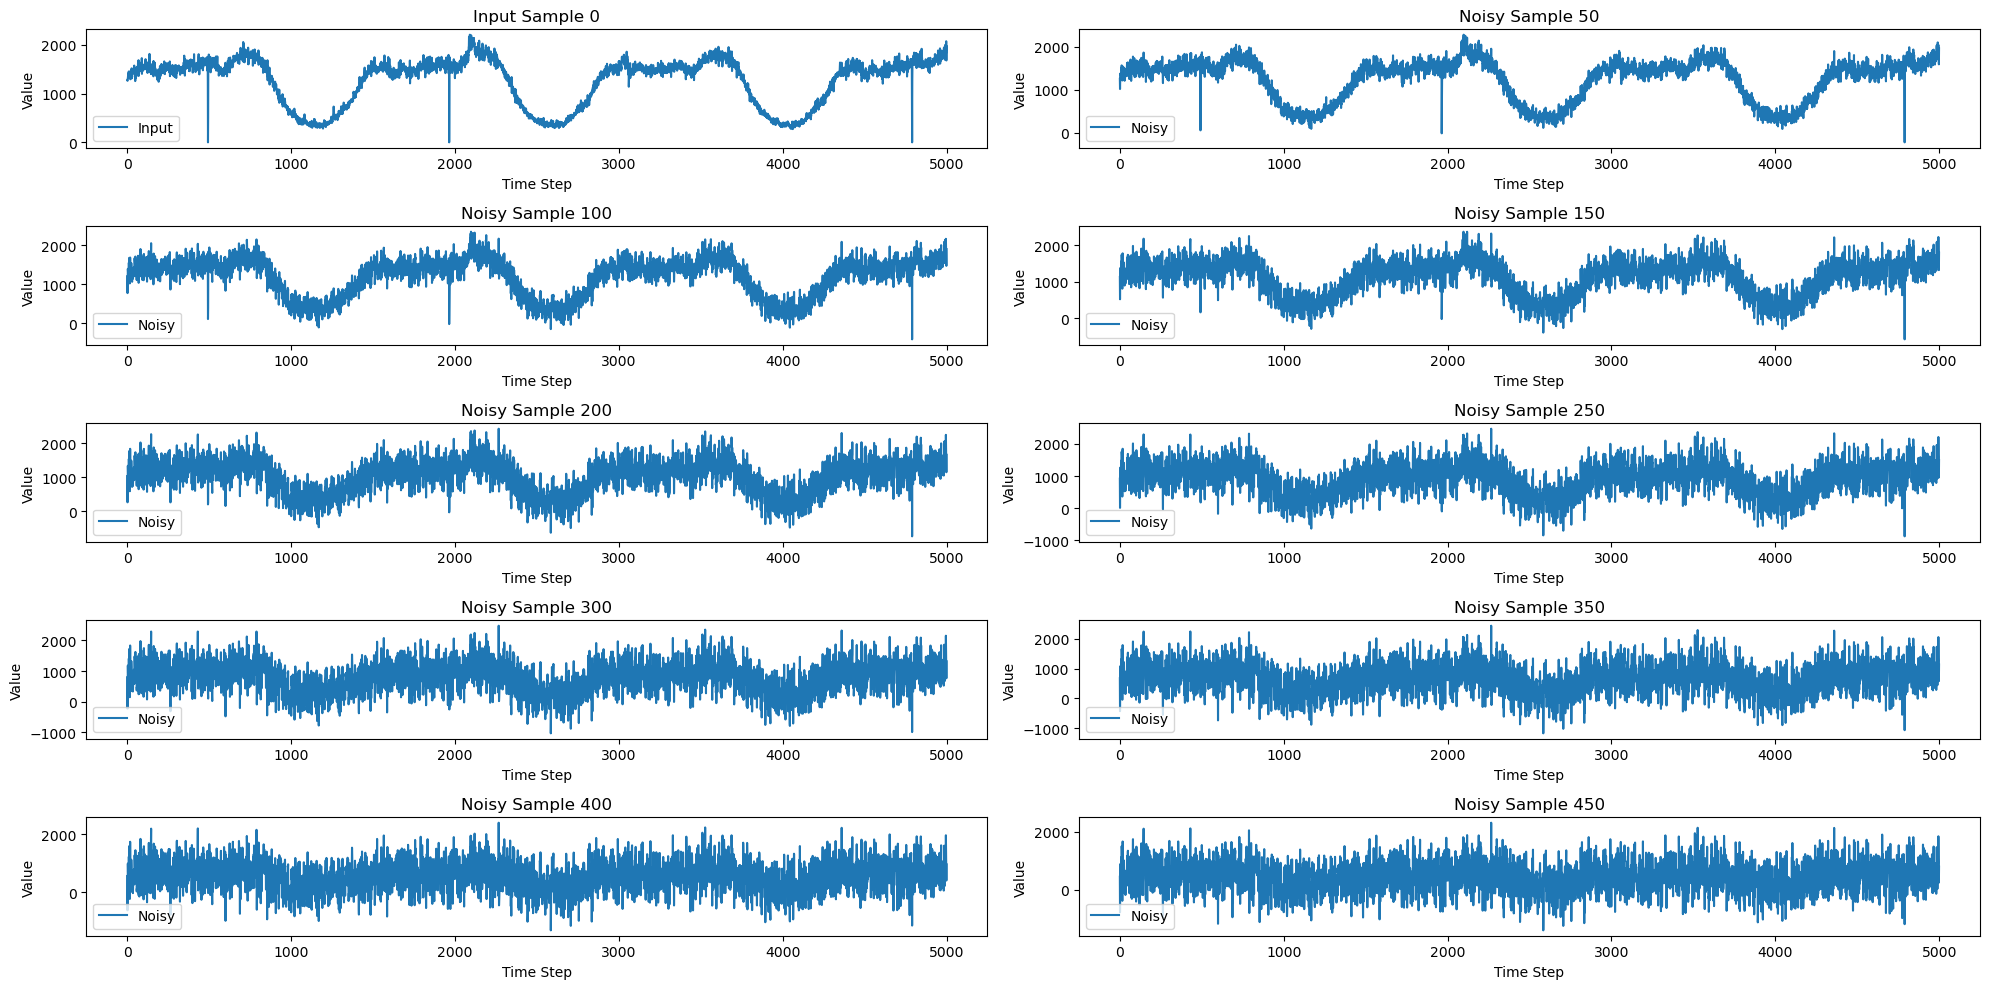

  0%|          | 0/1 [00:00<?, ?it/s]


In [52]:

noise_scheduler = PinkNoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

for epoch in range(config.num_epochs):

    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch, timestamps, labels) in enumerate(tqdm(dataloader)):
        #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)
        
        print(step)
        print(batch)
        print(timestamps)
        print(labels)
        
        noise = noise_scheduler.generate_pink_noise_like(batch) * std_batch
        
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        print('timesteps', timesteps)

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        
        print(f"Batch shape: {batch.shape}")
        print(f"Noise shape: {noise.shape}")
        print(f"Noisy shape: {noisy.shape}")
        

        # Visualize the input and noisy data 
        fig, axs = plt.subplots(5, 2, figsize=(20, 10))
        
        # Plotting the first sample
        ax = axs[0, 0]
        ax.plot(batch[0].cpu().numpy())
        ax.set_title("Input Sample 0")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Input"])

        # Plotting noisy versions of the first sample
        for i in range(9):
            noisy_sample = noise_scheduler.add_noise(batch[0], noise[0], torch.tensor([(i+1)*50]))
            ax = axs[(i+1) // 2, (i+1) % 2]
            ax.plot(noisy_sample[0].cpu().numpy())
            ax.set_title(f"Noisy Sample {(i+1)*50}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Value")
            ax.legend(["Noisy"])

        fig.tight_layout()
        plt.show()
        
        break

# Brownian noise

In [54]:
from noise_scheduler import BrownianNoiseScheduler

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

0
tensor([[1273., 1263., 1307.,  ..., 2076., 1681., 1972.],
        [1708., 1760., 1608.,  ...,  319.,  345.,  402.],
        [ 571.,  621.,  572.,  ..., 1596., 1611., 1589.],
        ...,
        [1860., 1845., 1872.,  ..., 1280., 1312., 1254.],
        [ 454.,  503.,  535.,  ..., 1577., 1577.,  668.],
        [1796., 1729., 1796.,  ...,  668.,  734.,  625.]])
tensor([1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5046e+09, 1.5046e+09, 1.5046e+09,
        1.5047e+09, 1.5047e+09, 1.5047e+09, 1.5048e+09, 1.5048e+09, 1.5048e+09,
        1.5048e+09, 1.5049e+09, 1.5049e+09, 1.5049e+09], dtype=torch.float64)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
timesteps tensor([353, 291, 106,  66,  39, 776, 740, 147, 772, 529, 292, 322, 973, 689,
        430,  51])
Batch shape: tor

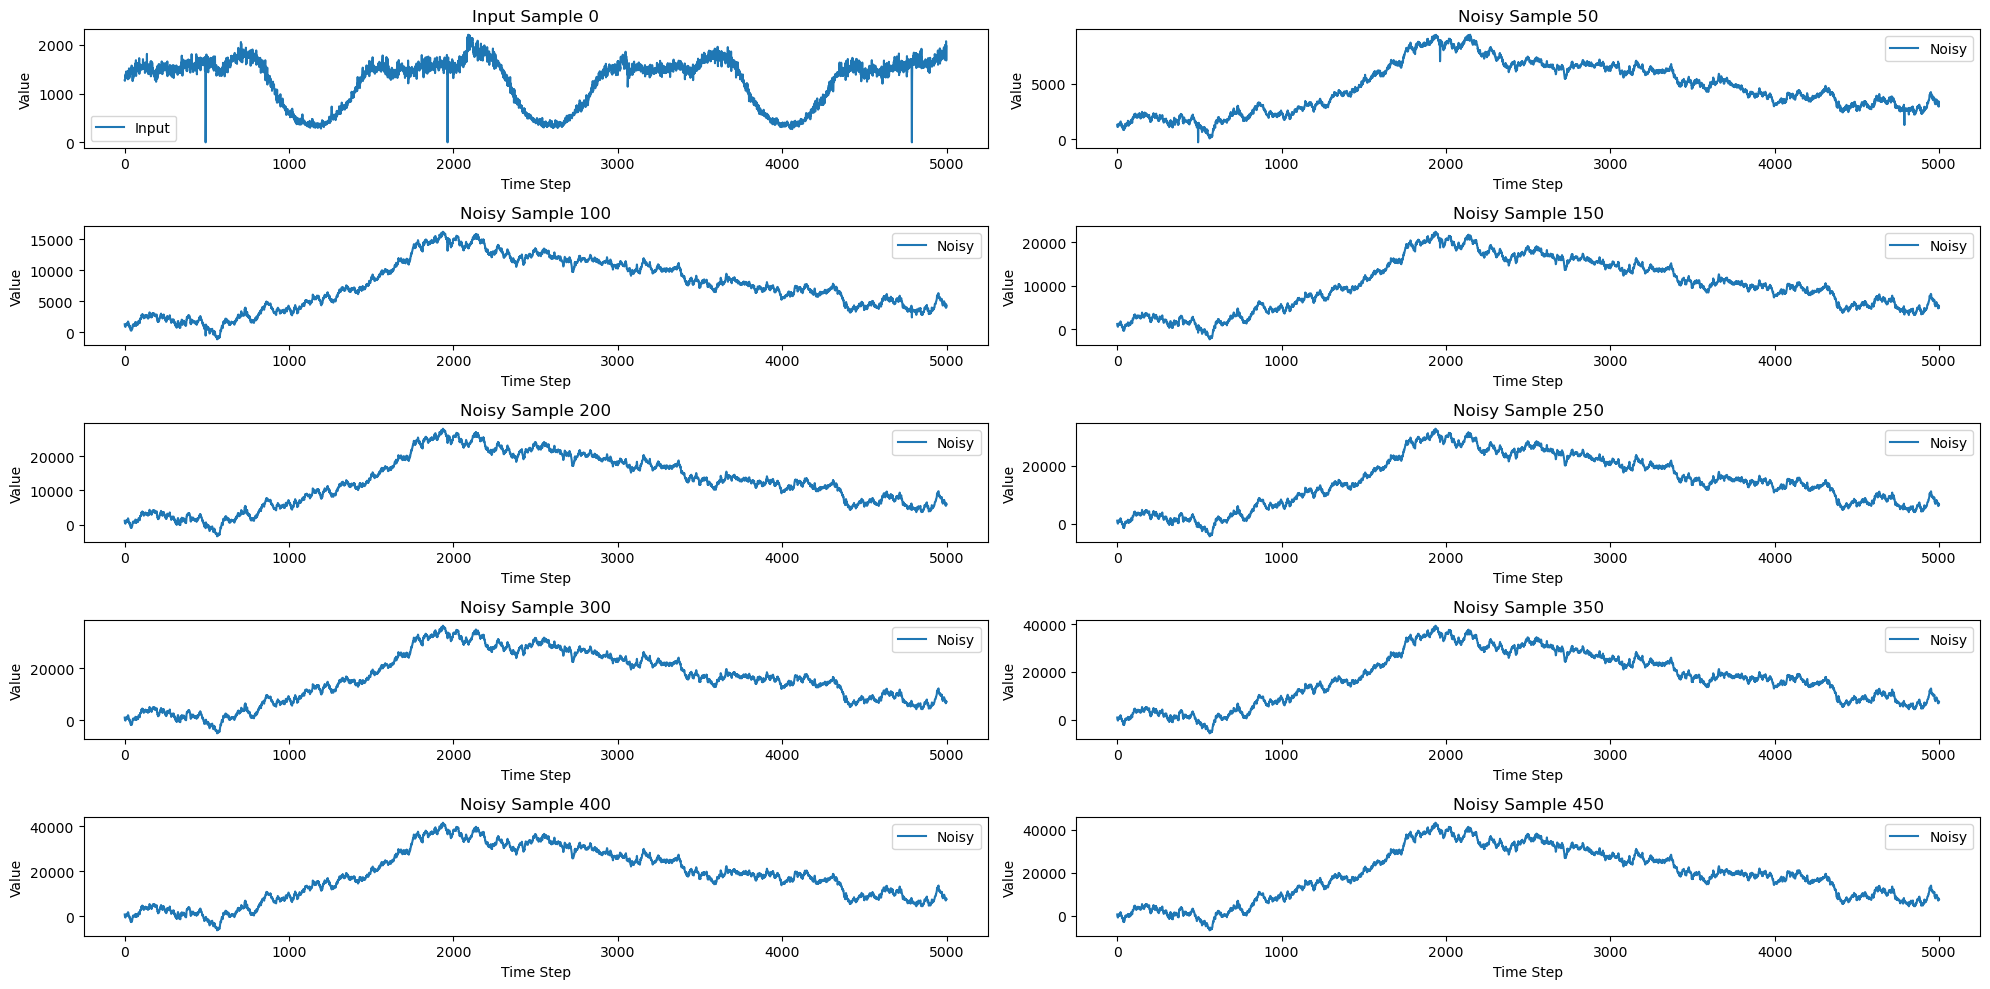

  0%|          | 0/1 [00:00<?, ?it/s]


In [57]:

noise_scheduler = BrownianNoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

for epoch in range(config.num_epochs):

    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch, timestamps, labels) in enumerate(tqdm(dataloader)):
        #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)
        
        print(step)
        print(batch)
        print(timestamps)
        print(labels)
        
        noise = noise_scheduler.generate_brownian_noise_like(batch)*std_batch
        
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        print('timesteps', timesteps)

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        
        print(f"Batch shape: {batch.shape}")
        print(f"Noise shape: {noise.shape}")
        print(f"Noisy shape: {noisy.shape}")
        

        # Visualize the input and noisy data 
        fig, axs = plt.subplots(5, 2, figsize=(20, 10))
        
        # Plotting the first sample
        ax = axs[0, 0]
        ax.plot(batch[0].cpu().numpy())
        ax.set_title("Input Sample 0")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Input"])

        # Plotting noisy versions of the first sample
        for i in range(9):
            noisy_sample = noise_scheduler.add_noise(batch[0], noise[0], torch.tensor([(i+1)*50]))
            ax = axs[(i+1) // 2, (i+1) % 2]
            ax.plot(noisy_sample[0].cpu().numpy())
            ax.set_title(f"Noisy Sample {(i+1)*50}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Value")
            ax.legend(["Noisy"])

        fig.tight_layout()
        plt.show()
        
        break